# Hailey Chung ECE475 Project 4 (Wine Quality)

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import os 
import sklearn

from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

In [3]:
# https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?resource=download
filename = os.path.join(os.getcwd(),"winequality-red.csv")
df = pd.read_csv(filename)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
# Creating Labels and Features
y = df['quality']
X = df.drop(columns='quality',inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 723)

In [7]:
# random forest for m = 2
test_error_1 = []
for i in range(0,100):
    model1 = RandomForestRegressor(n_estimators = (i*10)+1, max_features = 2)
    model1.fit(X_train, y_train)
    y_pred = model1.predict(X_test)
    error = (abs(y_test - y_pred)).mean()
    test_error_1.append(error)

In [8]:
# random forest for m = 6
test_error_2 = []
for i in range(0,100):
    model2 = RandomForestRegressor(n_estimators = (i*10)+1, max_features = 6)
    model2.fit(X_train, y_train)
    y_pred = model2.predict(X_test)
    error = (abs(y_test - y_pred)).mean()
    test_error_2.append(error)

In [9]:
# xgb model for GBM depth = 4
model3 = xgb.XGBRegressor(max_depth = 4, learning_rate = 0.05, colsample_bytree=0.5, objective = "reg:pseudohubererror", n_estimators = 1000, eval_metric = mean_absolute_error, alpha=0)
model3.fit(X_train, y_train, eval_set = [(X_train, y_train),(X_test, y_test)],verbose=0)
errors3 = model3.evals_result()
test_error_3 = np.array(errors3['validation_1']['mean_absolute_error'])

In [10]:
# xgb model for GBM depth = 6
model4 = xgb.XGBRegressor(max_depth = 6, learning_rate = 0.05, colsample_bytree=0.5, objective = "reg:pseudohubererror", n_estimators = 1000, eval_metric = mean_absolute_error, alpha=0)
model4.fit(X_train, y_train, eval_set = [(X_train, y_train),(X_test, y_test)],verbose=0)
errors4 = model4.evals_result()
test_error_4 = np.array(errors4['validation_1']['mean_absolute_error'])

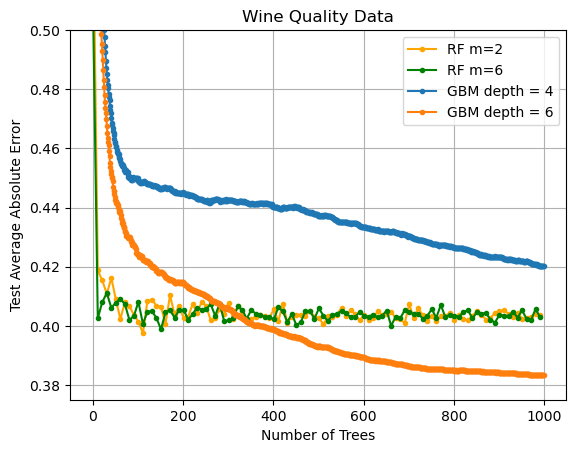

In [12]:
# Replicating Figure 15.3
fig, ax = plt.subplots()
n = np.zeros(100)
for i in range(0,100):
    n[i] = (i*10)+1
ax.plot(n, test_error_1, label = 'RF m=2', color = 'orange', marker = 'o', markersize = 3)
ax.plot(n, test_error_2, label = 'RF m=6', color = 'green', marker = 'o', markersize = 3)
ax.plot(test_error_3, label = 'GBM depth = 4', marker = 'o', markersize = 3)
ax.plot(test_error_4, label = 'GBM depth = 6', marker = 'o', markersize = 3)
ax.set(xlabel='Number of Trees', ylabel='Test Average Absolute Error',title='Wine Quality Data')
ax.grid()
ax.legend()
plt.ylim([0.375,0.5])
plt.show()

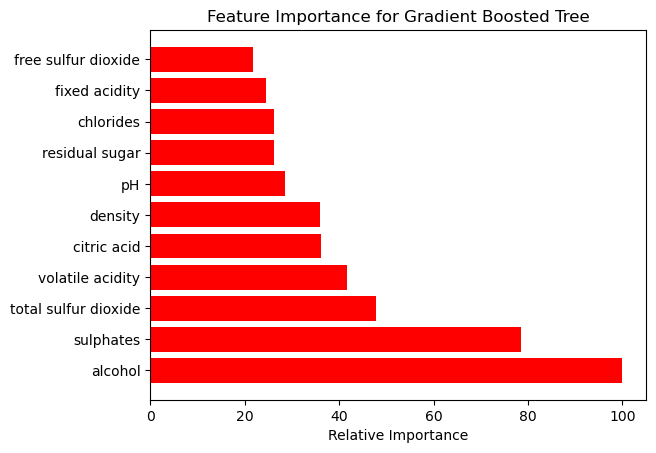

In [13]:
# Feature Importance for Gradient Boosted Tree (GBM depth=4):
index = model3.feature_importances_.argsort()
imp = model3.feature_importances_[index][::-1]
relimp = (imp/max(imp))*100
feats = model3.feature_names_in_[index][::-1]
plt.barh(feats,relimp, color = 'red')
plt.xlabel("Relative Importance")
plt.title("Feature Importance for Gradient Boosted Tree")
plt.show()

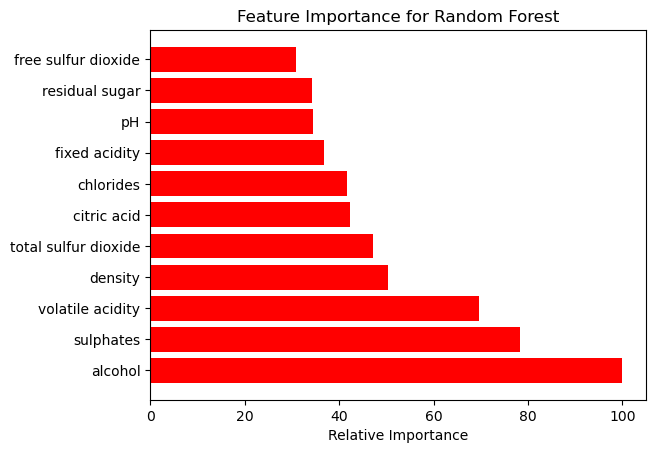

In [14]:
# Feature Importance for Random Forest (RF m=2):
index = model1.feature_importances_.argsort()
imp = model1.feature_importances_[index][::-1]
relimp = (imp/max(imp))*100
feats = model1.feature_names_in_[index][::-1]
plt.barh(feats,relimp, color = 'red')
plt.xlabel("Relative Importance")
plt.title("Feature Importance for Random Forest")
plt.show()